# Evaporation

In [21]:
# Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr
import pandas as pd

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature


import os
import sys
import json
from zipfile import ZipFile
import time
import base64
from IPython.core.display import HTML

import requests
import warnings
warnings.filterwarnings('ignore')

In [22]:
pip install -U hda

Note: you may need to restart the kernel to use updated packages.


In [23]:
import requests
import tqdm
from hda import Client, Configuration

In [15]:
dataset_id = "EO:ECMWF:DAT:REANALYSIS_ERA5_SINGLE_LEVELS_MONTHLY_MEANS"

In [16]:
{
  "dataset_id": "EO:ECMWF:DAT:REANALYSIS_ERA5_SINGLE_LEVELS_MONTHLY_MEANS",
  "itemsPerPage": 200,
  "startIndex": 0
}

{'dataset_id': 'EO:ECMWF:DAT:REANALYSIS_ERA5_SINGLE_LEVELS_MONTHLY_MEANS',
 'itemsPerPage': 200,
 'startIndex': 0}

In [17]:
data = {
  "dataset_id": "EO:ECMWF:DAT:REANALYSIS_ERA5_SINGLE_LEVELS_MONTHLY_MEANS",
  "product_type": [
    "monthly_averaged_reanalysis"
  ],
  "variable": [
    "evaporation"
  ],
  "year": [
    "1979",
    "1980",
    "1981",
    "1982",
    "1983",
    "1984",
    "1985",
    "1986",
    "1987",
    "1988",
    "1989",
    "1990",
    "1991",
    "1992",
    "1993",
    "1994",
    "1995",
    "1996",
    "1997",
    "1998",
    "1999",
    "2000",
    "2001",
    "2002",
    "2003",
    "2004",
    "2005",
    "2006",
    "2007",
    "2008",
    "2009",
    "2010",
    "2011",
    "2012",
    "2013",
    "2014",
    "2015",
    "2016",
    "2017",
    "2018",
    "2019",
    "2020",
    "2021",
    "2022",
    "2023"
      ],
  
  "month": [
    "01",
    "02",
    "03",
    "04",
    "05",
    "06",
    "07",
    "08",
    "09",
    "10", 
    "11",
    "12"],
  "time": [
    "00:00",
    "06:00",
    "12:00",
    "18:00"
  ],
  "bbox": [
    -180,
    90,
    180,
    60
  ],
  "format": "netcdf",
  "itemsPerPage": 200,
  "startIndex": 0
}

In [23]:
#def load_data():
conf = Configuration(user = "zcasty", password = "green1234Zaria")
    #hda_client = Client(config = conf)
    #c = Client(debug=True)
c = Client(config=conf, max_workers=12)
matches = c.search(data)
print(matches)
matches.download()

SearchResults[items=1,volume=ND]


In [18]:
# get filename of latest .nc downloaded file 
files = [file for file in os.listdir(".") if (file.lower().endswith('.nc'))]
list_nc_file = [] 

for file in sorted(files,key=os.path.getmtime, reverse=True):
    list_nc_file.append(file)
    
print(f'Selected netCDF file: {list_nc_file[0]}')  

Selected netCDF file: reanalysis-era5-single-levels-monthly-means-29e8a7e8534606fb14b33f4663c093f4.nc


# Evaporation

In [19]:
file_path = "reanalysis-era5-single-levels-monthly-means-29e8a7e8534606fb14b33f4663c093f4.nc"

ds = xr.open_dataset(file_path)
print(ds)

e = ds['e'] 

<xarray.Dataset>
Dimensions:     (valid_time: 540, latitude: 121, longitude: 1440)
Coordinates:
    number      int64 ...
  * valid_time  (valid_time) datetime64[ns] 1979-01-01T06:00:00 ... 2023-12-0...
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... 60.5 60.25 60.0
  * longitude   (longitude) float64 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
    expver      (valid_time) object ...
Data variables:
    e           (valid_time, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-11T17:32 GRIB to CDM+CF via cfgrib-0.9.1...


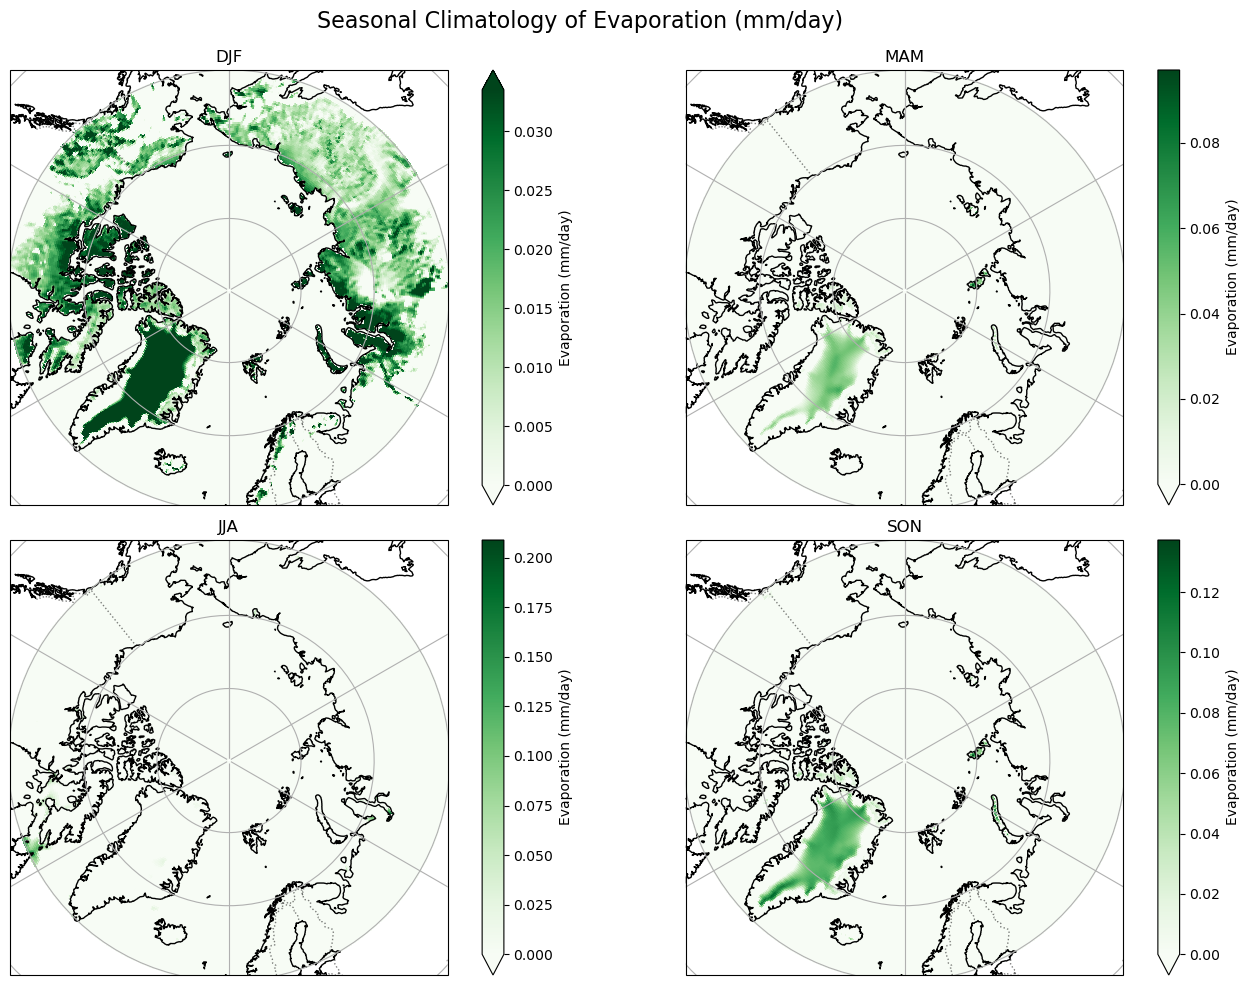

In [20]:
# STEP 1: Load dataset
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

e = e.rename({'valid_time': 'time'})  # rename for grouping

# STEP 3: Group by season and compute mean
e_season = e.groupby('time.season').mean('time', skipna=True)

# STEP 4: Plot seasonal climatology (4-panel map)
seasons = ['DJF', 'MAM', 'JJA', 'SON']

fig, axs = plt.subplots(2, 2, figsize=(14, 10), subplot_kw={'projection': ccrs.NorthPolarStereo()})
fig.suptitle('Seasonal Climatology of Evaporation (mm/day)', fontsize=16)

for ax, season in zip(axs.flat, seasons):
    evaporation = e_season.sel(season=season) * 1000  # convert from m to mm

    # Safety check for valid vmax
    vmax = np.nanpercentile(evaporation, 95)
    if np.isnan(vmax) or vmax <= 0:
        vmax = np.nanmax(evaporation)
    if np.isnan(vmax) or vmax <= 0:
        print(f"{season} has no valid data.")
        continue

    evaporation.plot.pcolormesh(
        ax=ax,
        transform=ccrs.PlateCarree(),
        x='longitude',
        y='latitude',
        cmap='Greens',
        vmin=0,
        vmax=vmax,
        cbar_kwargs={'label': 'Evaporation (mm/day)'}
    )

    ax.set_title(season)
    ax.coastlines()
    ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.5)
    ax.gridlines(draw_labels=False)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


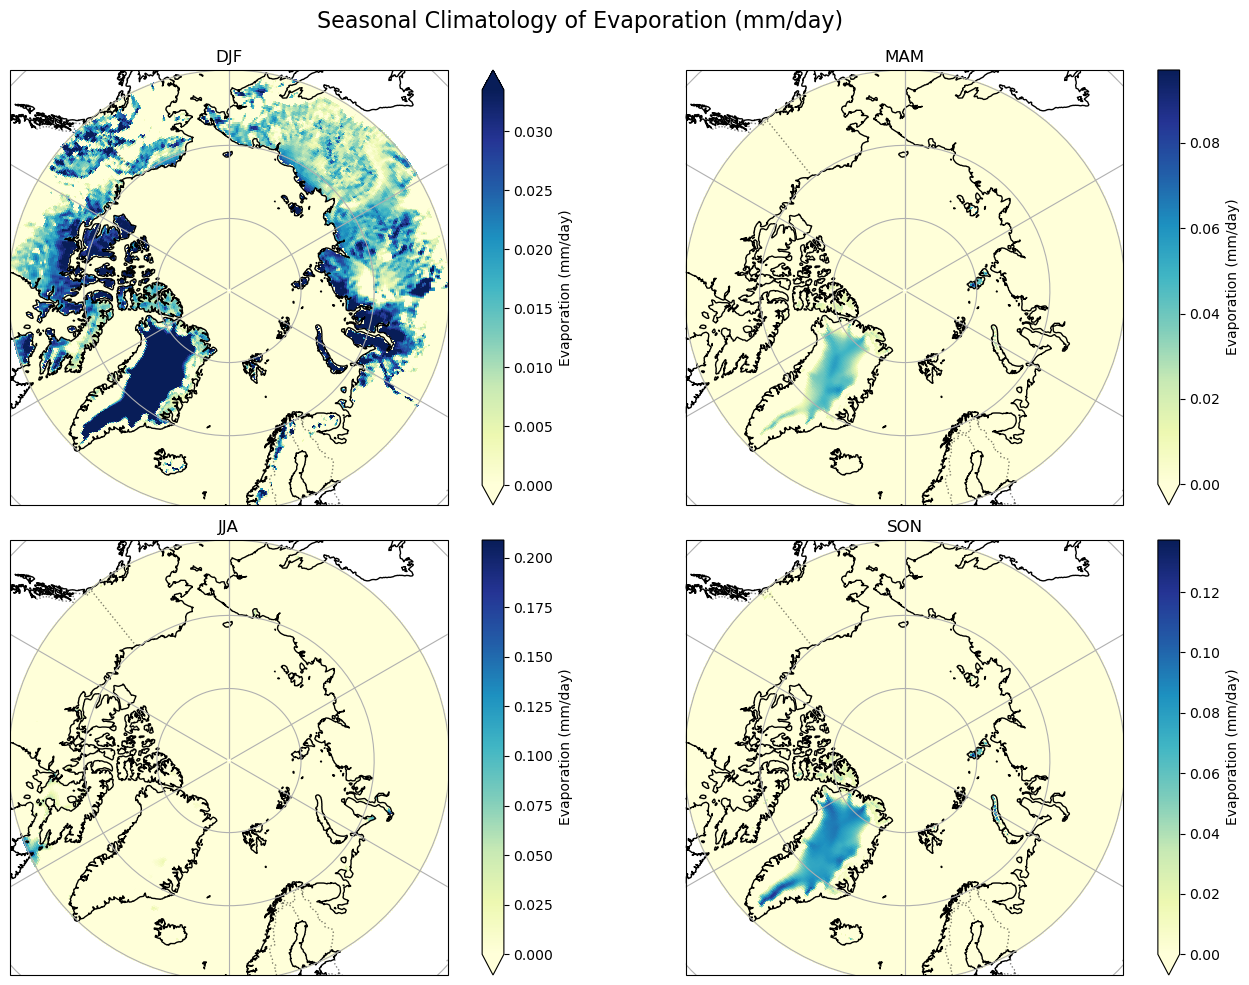

In [52]:
# STEP 1: Load dataset
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

e = e.rename({'valid_time': 'time'})  # rename for grouping

# STEP 3: Group by season and compute mean
e_season = e.groupby('time.season').mean('time', skipna=True)

# STEP 4: Plot seasonal climatology (4-panel map)
seasons = ['DJF', 'MAM', 'JJA', 'SON']

fig, axs = plt.subplots(2, 2, figsize=(14, 10), subplot_kw={'projection': ccrs.NorthPolarStereo()})
fig.suptitle('Seasonal Climatology of Evaporation (mm/day)', fontsize=16)

for ax, season in zip(axs.flat, seasons):
    evaporation = e_season.sel(season=season) * 1000  # convert from m to mm

    # Safety check for valid vmax
    vmax = np.nanpercentile(evaporation, 95)
    if np.isnan(vmax) or vmax <= 0:
        vmax = np.nanmax(evaporation)
    if np.isnan(vmax) or vmax <= 0:
        print(f"{season} has no valid data.")
        continue

    evaporation.plot.pcolormesh(
        ax=ax,
        transform=ccrs.PlateCarree(),
        x='longitude',
        y='latitude',
        cmap='YlGnBu',
        vmin=0,
        vmax=vmax,
        cbar_kwargs={'label': 'Evaporation (mm/day)'}
    )

    ax.set_title(season)
    ax.coastlines()
    ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.5)
    ax.gridlines(draw_labels=False)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


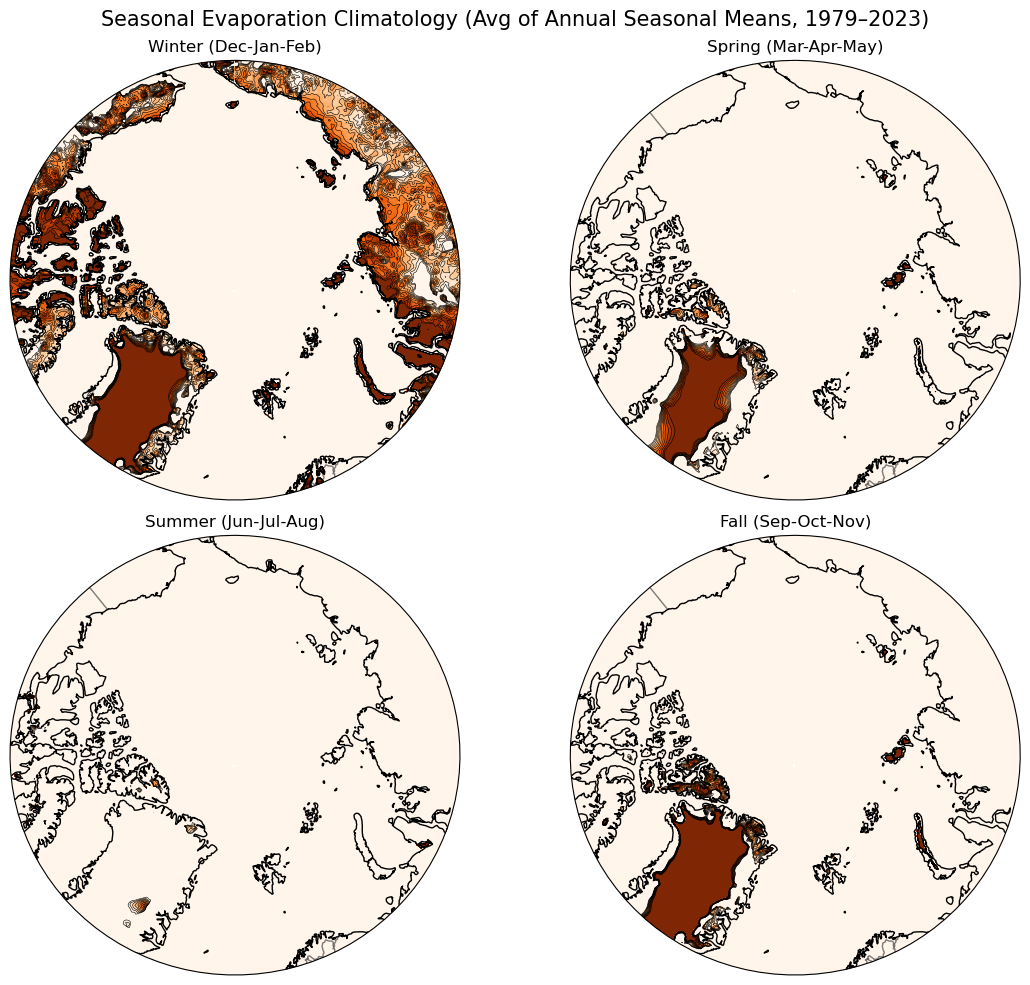

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr

def plot_seasonal_evaporation(e, title_prefix='Seasonal Evaporation Climatology', cmap='Oranges', vmin=0, vmax=None):
    # Seasonal month groups
    seasons = {
        'Winter (Dec-Jan-Feb)': [12, 1, 2],
        'Spring (Mar-Apr-May)': [3, 4, 5],
        'Summer (Jun-Jul-Aug)': [6, 7, 8],
        'Fall (Sep-Oct-Nov)': [9, 10, 11]
    }

    fig, axes = plt.subplots(2, 2, figsize=(12, 10),
                             subplot_kw={'projection': ccrs.Orthographic(central_latitude=90)})

    for ax, (season, months) in zip(axes.flat, seasons.items()):
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)

        # Circular boundary mask
        theta = np.linspace(0, 2 * np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax.set_boundary(circle, transform=ax.transAxes)
        ax.set_extent([-180, 180, 66.5, 90], crs=ccrs.PlateCarree())

        # Filter data for selected season
        e_season = e.sel(time=e['time'].dt.month.isin(months))

        # Group by year and average annually
        e_annual = e_season.groupby('time.year').mean(dim='time')

        # Compute mean across years
        with xr.set_options(keep_attrs=True):
            seasonal_mean = e_annual.mean(dim='year')

        # Handle vmax if not given
        if vmax is None:
            vmax = np.nanpercentile(seasonal_mean, 95)

        # Plot with filled contours
        pp = ax.pcolormesh(seasonal_mean.longitude, seasonal_mean.latitude, seasonal_mean,
                           transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)

        # Add contour lines
        contours = ax.contour(seasonal_mean.longitude, seasonal_mean.latitude, seasonal_mean,
                              levels=np.linspace(vmin, vmax, 11), colors='black', linewidths=0.4,
                              transform=ccrs.PlateCarree())

        ax.set_title(season)

    plt.suptitle(f'{title_prefix} (Avg of Annual Seasonal Means, 1979–2023)', fontsize=15)
    plt.tight_layout()
    plt.show()

# EXAMPLE USAGE:
# Load evaporation data (in mm/day)
#ds = xr.open_dataset("reanalysis-era5-single-levels-monthly-means-2a2807dd1b1f799add59938e954c332b.nc")
e = ds['e'].rename({'valid_time': 'time'}) * 1000  # convert to mm/day

# Call the plot function
plot_seasonal_evaporation(e, title_prefix='Seasonal Evaporation Climatology', cmap='Oranges', vmin=0)



# Surface Heat Flux

In [54]:
data = {
  "dataset_id": "EO:ECMWF:DAT:REANALYSIS_ERA5_SINGLE_LEVELS_MONTHLY_MEANS",
  "product_type": [
    "monthly_averaged_reanalysis"
  ],
  "variable": [
    "surface_latent_heat_flux"
  ],
  "year": [
    "1979",
    "1980",
    "1981",
    "1982",
    "1983",
    "1984",
    "1985",
    "1986",
    "1987",
    "1988",
    "1989",
    "1990",
    "1991",
    "1992",
    "1993",
    "1994",
    "1995",
    "1996",
    "1997",
    "1998",
    "1999",
    "2000",
    "2001",
    "2002",
    "2003",
    "2004",
    "2005",
    "2006",
    "2007",
    "2008",
    "2009",
    "2010",
    "2011",
    "2012",
    "2013",
    "2014",
    "2015",
    "2016",
    "2017",
    "2018",
    "2019",
    "2020",
    "2021",
    "2022",
    "2023"
      ],
  
  "month": [
    "01",
    "02",
    "03",
    "04",
    "05",
    "06",
    "07",
    "08",
    "09",
    "10", 
    "11",
    "12"],
  "time": [
    "00:00",
    "06:00",
    "12:00",
    "18:00"
  ],
  "bbox": [
    -180,
    90,
    180,
    60
  ],
  "format": "netcdf",
  "itemsPerPage": 200,
  "startIndex": 0
}

In [9]:
#def load_data():
conf = Configuration(user = "zcasty", password = "green1234Zaria")
    #hda_client = Client(config = conf)
    #c = Client(debug=True)
c = Client(config=conf, max_workers=12)
matches = c.search(data)
print(matches)
matches.download()

SearchResults[items=1,volume=ND]


In [55]:
# get filename of latest .nc downloaded file 
files = [file for file in os.listdir(".") if (file.lower().endswith('.nc'))]
list_nc_file = [] 

for file in sorted(files,key=os.path.getmtime, reverse=True):
    list_nc_file.append(file)
    
print(f'Selected netCDF file: {list_nc_file[0]}')  

Selected netCDF file: reanalysis-era5-single-levels-monthly-means-29e8a7e8534606fb14b33f4663c093f4.nc


In [32]:
file_path = "reanalysis-era5-single-levels-monthly-means-6b00e1f3fc2180816dd8fb189f3e17d7.nc"

ds = xr.open_dataset(file_path)

slhf = ds['slhf']
evap = -1 * slhf

In [39]:
print(ds)

<xarray.Dataset>
Dimensions:     (valid_time: 540, latitude: 121, longitude: 1440)
Coordinates:
    number      int64 ...
  * valid_time  (valid_time) datetime64[ns] 1979-01-01T06:00:00 ... 2023-12-0...
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... 60.5 60.25 60.0
  * longitude   (longitude) float64 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
    expver      (valid_time) object ...
Data variables:
    slhf        (valid_time, latitude, longitude) float32 -1.383e+05 ... -1.0...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-06T15:35 GRIB to CDM+CF via cfgrib-0.9.1...


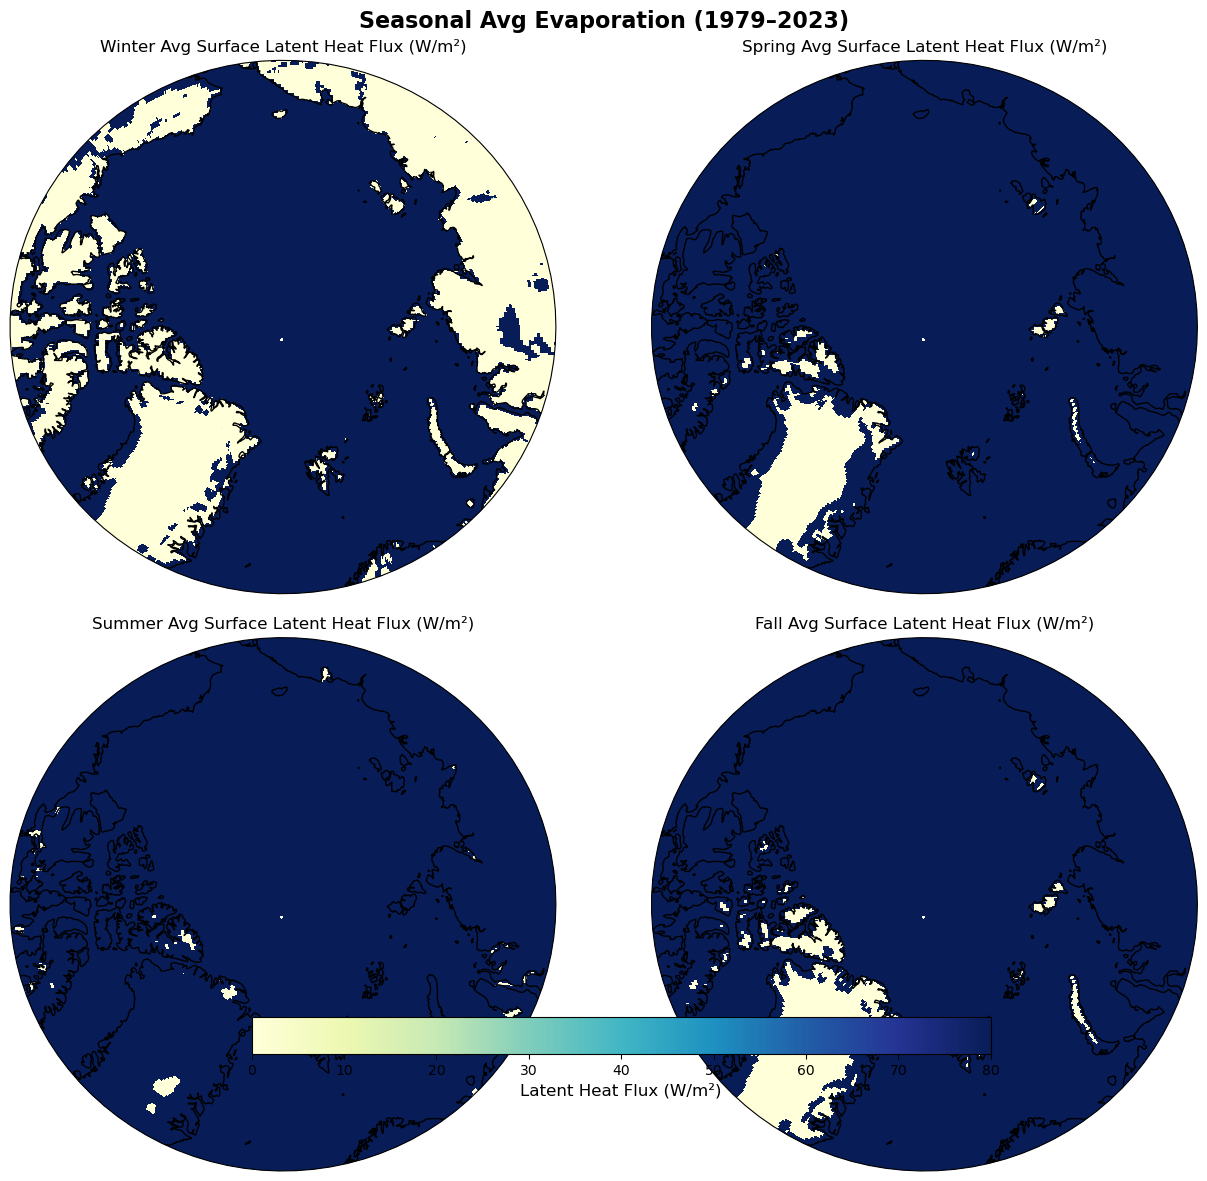

In [54]:
# --- Step 2: Flip sign so upward (evaporation) is positive ---
evap = -1 * slhf

# --- Step 3: Assign season and compute seasonal mean climatology ---
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

evap.coords['season'] = xr.apply_ufunc(
    np.vectorize(get_season), evap['valid_time'].dt.month
)
seasonal_mean = evap.groupby('season').mean(dim='valid_time')

# --- Step 4: Plot 4-panel seasonal climatology ---
def plot_seasonal_evaporation(data, title_prefix='Seasonal Avg Evaporation'):
    fig, axes = plt.subplots(2, 2, figsize=(14, 12),
                             subplot_kw={'projection': ccrs.Orthographic(central_latitude=90)})

    seasons = ['Winter', 'Spring', 'Summer', 'Fall']
    vmin, vmax = 0, 80  # Adjust if needed

    for i, ax in enumerate(axes.flat):
        ax.set_global()
        ax.coastlines()
        ax.add_feature(cfeature.LAND, facecolor='lightgray')

        theta = np.linspace(0, 2 * np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        circle = mpath.Path(np.vstack([np.cos(theta), np.sin(theta)]).T * radius + center)
        ax.set_boundary(circle, transform=ax.transAxes)
        ax.set_extent([-180, 180, 66.5, 90], crs=ccrs.PlateCarree())

        p = ax.pcolormesh(data.longitude, data.latitude, data.sel(season=seasons[i]),
                          transform=ccrs.PlateCarree(), cmap='YlGnBu',
                          vmin=vmin, vmax=vmax, shading='auto')
        ax.set_title(f"{seasons[i]} Avg Surface Latent Heat Flux (W/m²)", fontsize=12)

    cbar = fig.colorbar(p, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.05, fraction=0.04)
    cbar.set_label("Latent Heat Flux (W/m²)", fontsize=12)
    plt.suptitle(f"{title_prefix} (1979–2023)", fontsize=16, weight='bold')
    plt.tight_layout()
    plt.show()

# --- Run the plot ---
plot_seasonal_evaporation(seasonal_mean)

In [33]:
print(seasonal_mean)
print(seasonal_mean.isel(season=0).values.min(), seasonal_mean.isel(season=0).values.max())


<xarray.DataArray 'slhf' (season: 4, latitude: 121, longitude: 1440)>
array([[[2.40346154e-13, 2.40346154e-13, 2.40346154e-13, ...,
         2.40346154e-13, 2.40346154e-13, 2.40346154e-13],
        [2.11694499e-13, 2.11556521e-13, 2.11493800e-13, ...,
         2.12077087e-13, 2.11932848e-13, 2.11813626e-13],
        [2.07799462e-13, 2.07441960e-13, 2.07234945e-13, ...,
         2.08508192e-13, 2.08363952e-13, 2.08031509e-13],
        ...,
        [1.47670001e-11, 1.46680446e-11, 1.45454248e-11, ...,
         1.48136919e-11, 1.48382105e-11, 1.48028048e-11],
        [1.47740310e-11, 1.47621637e-11, 1.46576067e-11, ...,
         1.46672778e-11, 1.47375324e-11, 1.47997690e-11],
        [1.46514537e-11, 1.47056915e-11, 1.46648822e-11, ...,
         1.43535010e-11, 1.44776222e-11, 1.45975992e-11]],

       [[7.50190274e-13, 7.50190274e-13, 7.50190274e-13, ...,
         7.50190274e-13, 7.50190274e-13, 7.50190274e-13],
        [7.09207270e-13, 7.09012764e-13, 7.08868565e-13, ...,
         7.09

In [55]:
ds['slhf']



<xarray.DataArray 'slhf' (valid_time: 540, latitude: 121, longitude: 1440)>
array([[[-1.382560e+05, -1.382560e+05, ..., -1.382560e+05, -1.382560e+05],
        [-7.681600e+04, -7.681600e+04, ..., -7.681600e+04, -7.681600e+04],
        ...,
        [-6.212624e+06, -6.207504e+06, ..., -6.159376e+06, -6.213648e+06],
        [-6.165520e+06, -6.144016e+06, ..., -6.125584e+06, -6.187024e+06]],

       [[-7.966400e+04, -7.966400e+04, ..., -7.966400e+04, -7.966400e+04],
        [-2.864000e+03, -2.864000e+03, ..., -2.864000e+03, -2.864000e+03],
        ...,
        [-5.232432e+06, -5.261104e+06, ..., -5.106480e+06, -5.203760e+06],
        [-5.272368e+06, -5.293872e+06, ..., -5.092144e+06, -5.250864e+06]],

       ...,

       [[-1.740800e+05, -1.740800e+05, ..., -1.740800e+05, -1.740800e+05],
        [-1.239040e+05, -1.239040e+05, ..., -1.259520e+05, -1.249280e+05],
        ...,
        [-7.588864e+06, -7.640064e+06, ..., -7.545856e+06, -7.542784e+06],
        [-7.335936e+06, -7.411712e+06, ..., -7.246848e+06, -7.261184e+06]],

       [[-1.467200e+04, -1.467200e+04, ..., -1.467200e+04, -1.467200e+04],
        [ 3.550400e+04,  3.652800e+04, ...,  3.550400e+04,  3.550400e+04],
        ...,
        [-1.080968e+07, -1.096738e+07, ..., -1.062024e+07, -1.064686e+07],
        [-1.015739e+07, -1.028846e+07, ..., -1.002530e+07, -1.002734e+07]]],
      dtype=float32)
Coordinates:
    number      int64 ...
  * valid_time  (valid_time) datetime64[ns] 1979-01-01T06:00:00 ... 2023-12-0...
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... 60.5 60.25 60.0
  * longitude   (longitude) float64 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
    expver      (valid_time) object ...
Attributes: (12/32)
    GRIB_paramId:                             147
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      174240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgad
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               J m**-2
    long_name:                                Time-integrated surface latent ...
    units:                                    J m**-2
    standard_name:                            surface_upward_latent_heat_flux
    GRIB_surface:                             0.0

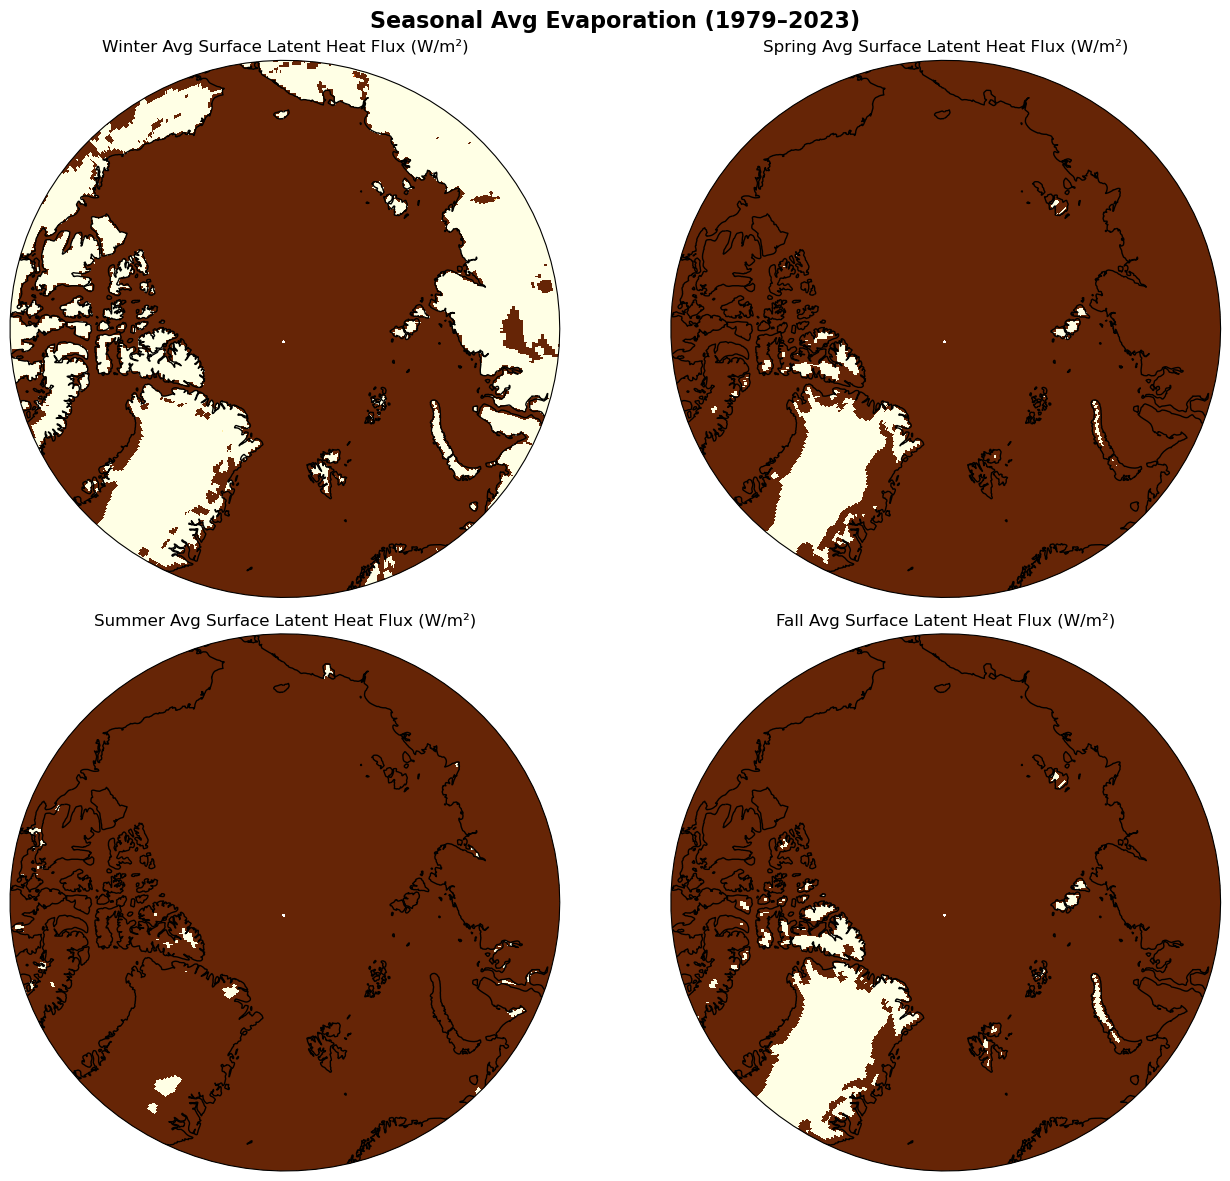

In [64]:
slhf = ds['slhf']          # Units: J/m² (monthly mean already averaged by ECMWF)
evap = -1 * slhf           # Flip sign → evaporation is positive (upward energy)

# --- Step 3: Assign season based on 'valid_time' dimension ---
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

# Create seasonal coordinate
evap.coords['season'] = xr.apply_ufunc(
    np.vectorize(get_season), evap['valid_time'].dt.month
)

# --- Step 4: Group by season and calculate mean ---
seasonal_mean = evap.groupby('season').mean(dim='valid_time')

# Optional: reorder to ['Winter', 'Spring', 'Summer', 'Fall']
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
seasonal_mean = seasonal_mean.sel(season=season_order)

# --- Step 5: Plot 4-panel Arctic evaporation climatology ---
def plot_seasonal_evaporation(data, title_prefix='Seasonal Avg Evaporation'):
    fig, axes = plt.subplots(2, 2, figsize=(14, 12),
                             subplot_kw={'projection': ccrs.Orthographic(central_latitude=90)})

    vmin, vmax = 0, 80
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']

    for i, ax in enumerate(axes.flat):
        ax.set_global()
        ax.coastlines()
        ax.add_feature(cfeature.LAND, facecolor='lightgray')

        # Arctic circular boundary
        theta = np.linspace(0, 2 * np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        circle = mpath.Path(np.vstack([np.cos(theta), np.sin(theta)]).T * radius + center)
        ax.set_boundary(circle, transform=ax.transAxes)
        ax.set_extent([-180, 180, 66.5, 90], crs=ccrs.PlateCarree())

        p = ax.pcolormesh(data.longitude, data.latitude, data.isel(season=i),
                          transform=ccrs.PlateCarree(), cmap='YlOrBr',
                          vmin=vmin, vmax=vmax, shading='auto')

        ax.set_title(f"{seasons[i]} Avg Surface Latent Heat Flux (W/m²)", fontsize=12)

    # Shared colorbar
    #cbar = fig.colorbar(p, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.05, fraction=0.04)
    #cbar.set_label("Latent Heat Flux (W/m²)", fontsize=12)

    plt.suptitle(f"{title_prefix} (1979–2023)", fontsize=16, weight='bold')
    plt.tight_layout()
    plt.show()

# --- Final step: Run the plot ---
plot_seasonal_evaporation(seasonal_mean)

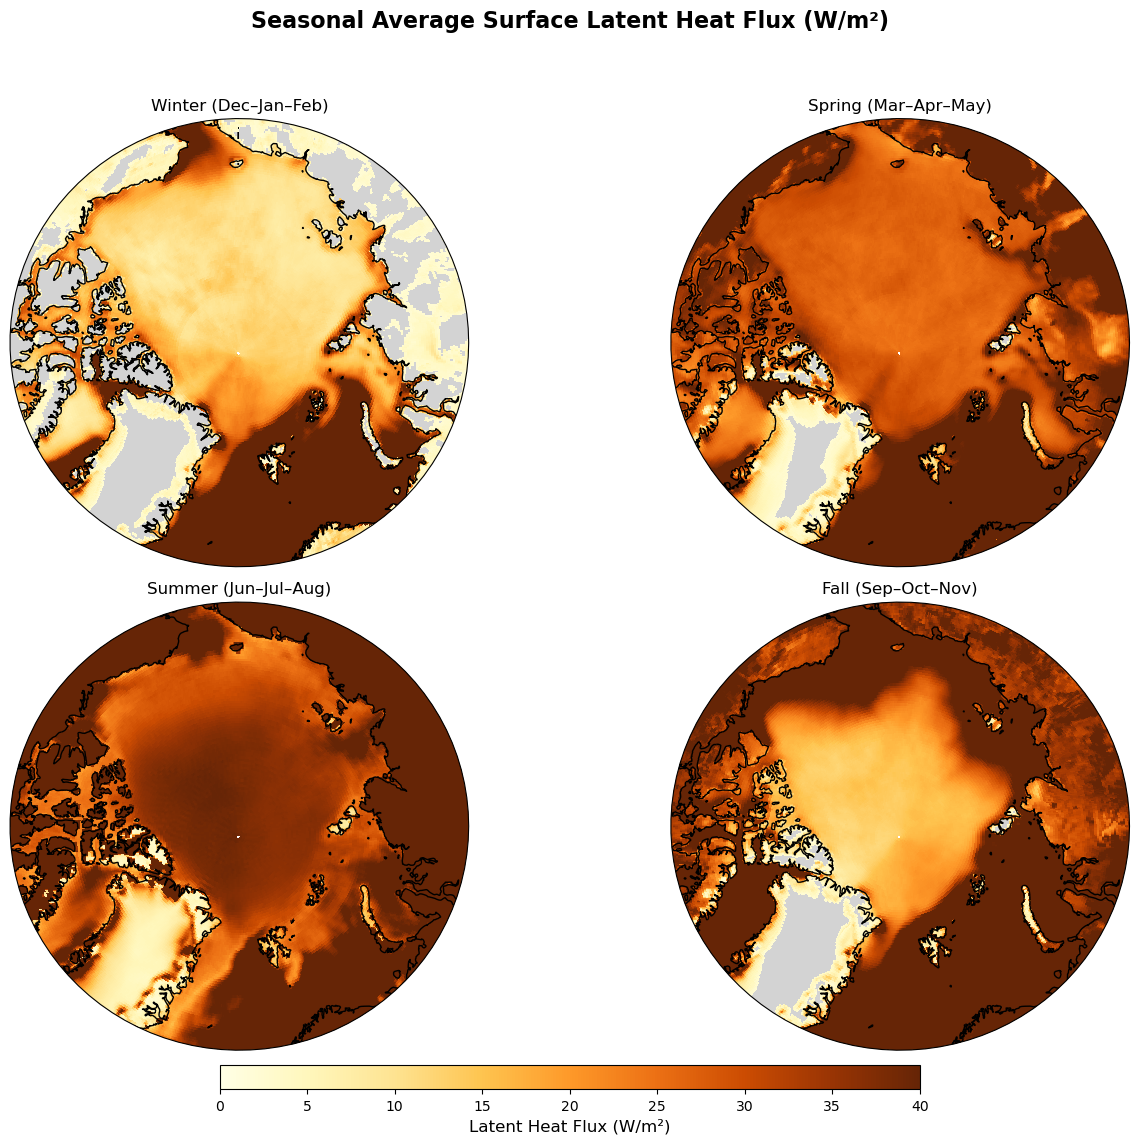

In [66]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpath

# --- Load and Convert SLHF ---
slhf = ds['slhf']  # Units: J/m² (accumulated per 6 hours)
evap = -1 * slhf / 21600  # Convert to W/m² (divide by 6 hrs = 21600 sec)

# --- Remove very small/noisy values ---
evap = evap.where(evap > 2)  # Mask low values often associated with ice

# --- Assign seasonal labels ---
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

# Apply season label to each time point
evap.coords['season'] = xr.apply_ufunc(
    np.vectorize(get_season),
    evap['valid_time'].dt.month
)

# --- Group and average by season ---
seasonal_mean = evap.groupby('season').mean(dim='valid_time')
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
seasonal_mean = seasonal_mean.sel(season=season_order)

# --- Plotting function ---
def plot_seasonal_evaporation(data, title_prefix='Seasonal Average Surface Latent Heat Flux (W/m²)'):
    fig, axes = plt.subplots(2, 2, figsize=(14, 12),
                             subplot_kw={'projection': ccrs.Orthographic(central_latitude=90)})

    vmin, vmax = 0, 40
    cmap = 'YlOrBr'
    seasons = [
        'Winter (Dec–Jan–Feb)',
        'Spring (Mar–Apr–May)',
        'Summer (Jun–Jul–Aug)',
        'Fall (Sep–Oct–Nov)'
    ]

    for i, ax in enumerate(axes.flat):
        ax.set_global()
        ax.coastlines()
        ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black')

        # Arctic circular boundary
        theta = np.linspace(0, 2 * np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        circle = mpath.Path(np.vstack([np.cos(theta), np.sin(theta)]).T * radius + center)
        ax.set_boundary(circle, transform=ax.transAxes)
        ax.set_extent([-180, 180, 66.5, 90], crs=ccrs.PlateCarree())

        p = ax.pcolormesh(
            data.longitude, data.latitude, data.isel(season=i),
            transform=ccrs.PlateCarree(), cmap=cmap,
            vmin=vmin, vmax=vmax, shading='auto'
        )

        ax.set_title(f"{seasons[i]}", fontsize=12)

    # Shared horizontal colorbar
    cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])  # [left, bottom, width, height]
    cbar = fig.colorbar(p, cax=cbar_ax, orientation='horizontal')
    cbar.set_label("Latent Heat Flux (W/m²)", fontsize=12)

    plt.suptitle(f"{title_prefix}", fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Adjust for title + colorbar
    plt.show()

# --- Final Step: Run the Plot ---
plot_seasonal_evaporation(seasonal_mean)


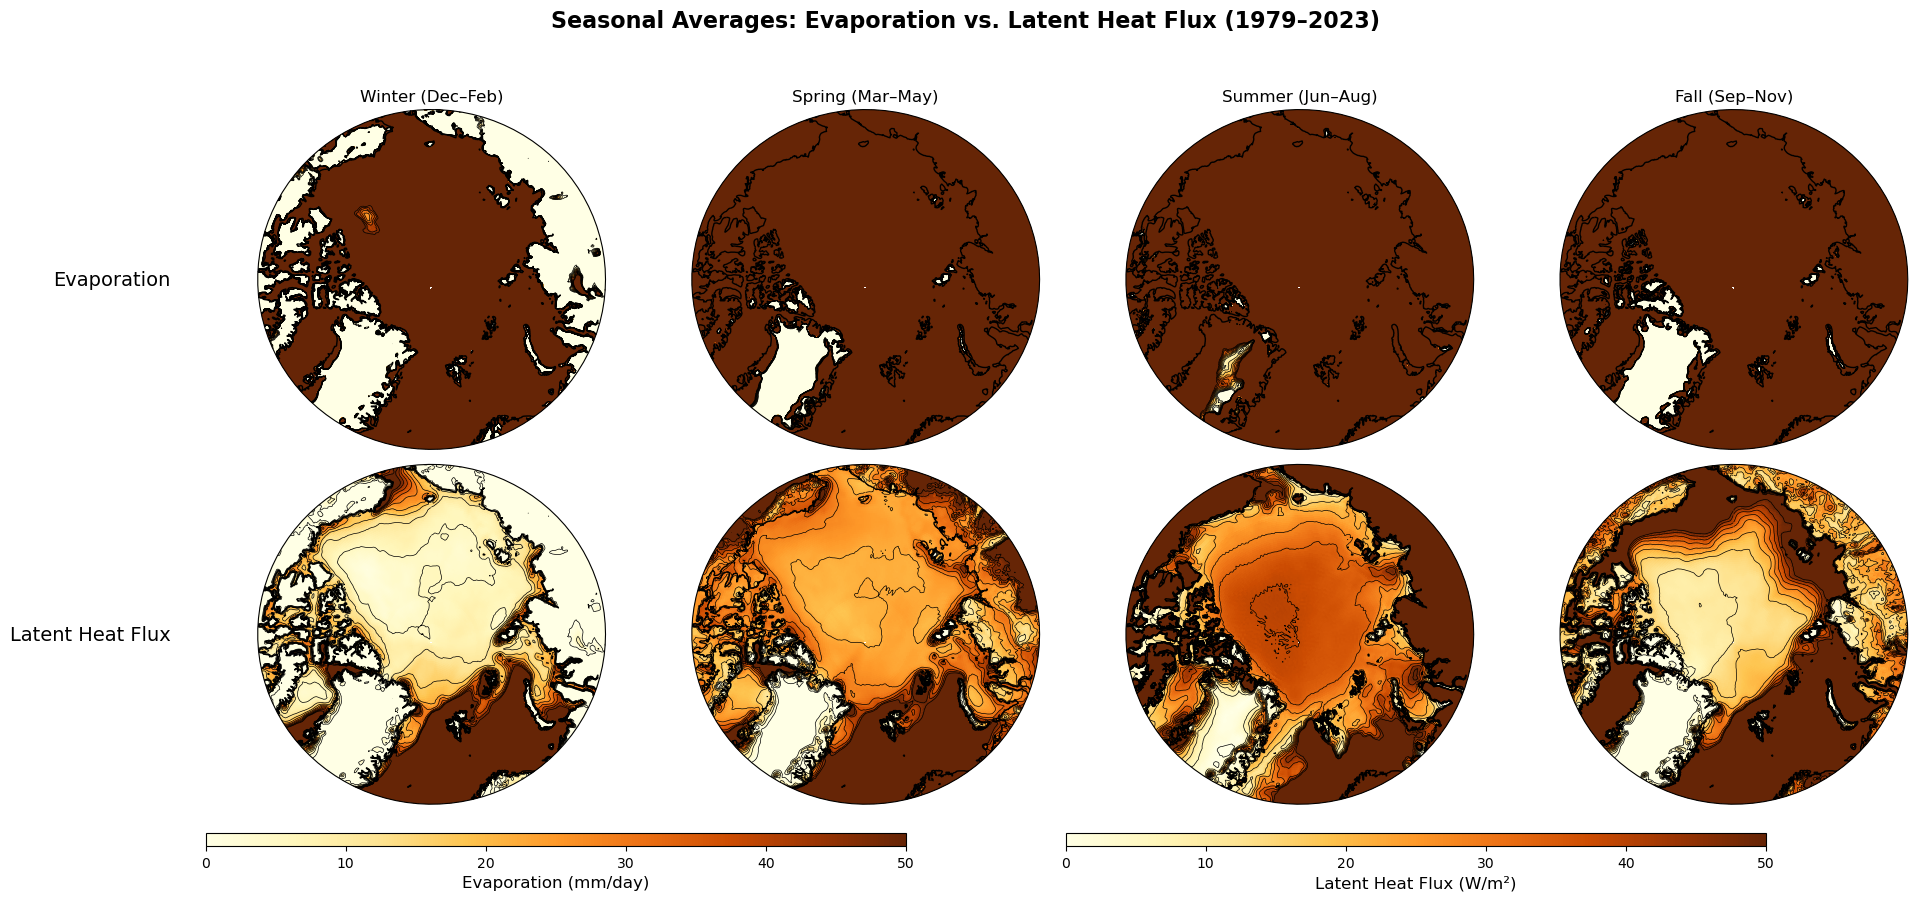

In [24]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpath

# --- Load Dataset ---
ds = xr.open_dataset("reanalysis-era5-single-levels-monthly-means-6b00e1f3fc2180816dd8fb189f3e17d7.nc") 

# --- Assign 'date' from valid_time ---
ds = ds.assign_coords(date=("valid_time", pd.to_datetime(ds.valid_time.values)))

# --- Extract SLHF ---
slhf = ds['slhf']  # Units: J/m² over 6-hour periods

# --- Compute Latent Heat Flux (W/m²) ---
latent_flux = -1 * slhf / 21600  # 6 hr = 21600 s, flip sign → upward positive

# --- Estimate Evaporation (mm/day) ---
# Formula: E (mm/day) = SLHF / Lv * (86400 / 21600) * 1000
# But simplified: E = -SLHF / 2.5e6 * 0.25 * 1000
evap_mm_day = (-1 * slhf / 2.5e6) * 250  # Final scaling factor

# --- Assign Seasons ---
def get_season(month):
    if month in [12, 1, 2]: return 'Winter (Dec–Feb)'
    elif month in [3, 4, 5]: return 'Spring (Mar–May)'
    elif month in [6, 7, 8]: return 'Summer (Jun–Aug)'
    else: return 'Fall (Sep–Nov)'

seasons = ['Winter (Dec–Feb)', 'Spring (Mar–May)', 'Summer (Jun–Aug)', 'Fall (Sep–Nov)']
season_labels = xr.apply_ufunc(
    np.vectorize(get_season, otypes=[str]),
    ds['date'].dt.month
)
evap_mm_day.coords['season'] = season_labels
latent_flux.coords['season'] = season_labels

# --- Compute Seasonal Averages ---
evap_seasonal = evap_mm_day.groupby('season').mean('valid_time').sel(season=seasons)
latent_seasonal = latent_flux.groupby('season').mean('valid_time').sel(season=seasons)

# --- Plot Function ---
def plot_seasonal_2x4(evap_data, slhf_data, cmap='YlOrBr', evap_vmax=5, slhf_vmax=50):
    fig, axes = plt.subplots(2, 4, figsize=(20, 9),
                             subplot_kw={'projection': ccrs.Orthographic(central_latitude=90)})

    for i, season in enumerate(seasons):
        for row, data in enumerate([evap_data, slhf_data]):
            ax = axes[row, i]
            ax.set_global()
            ax.coastlines()
            ax.add_feature(cfeature.LAND, facecolor='lightgray')
            ax.set_extent([-180, 180, 66.5, 90], crs=ccrs.PlateCarree())

            # Arctic boundary
            theta = np.linspace(0, 2 * np.pi, 100)
            circle = mpath.Path(np.vstack([np.cos(theta), np.sin(theta)]).T * 0.5 + 0.5)
            ax.set_boundary(circle, transform=ax.transAxes)

            dat = data.sel(season=season)
            vmax = evap_vmax if row == 0 else slhf_vmax
            vmin = 0

            p = ax.pcolormesh(dat.longitude, dat.latitude, dat,
                              transform=ccrs.PlateCarree(), cmap=cmap,
                              shading='auto', vmin=vmin, vmax=vmax)

            # Contours
            contour_levels = np.linspace(vmin, vmax, 10)
            ax.contour(dat.longitude, dat.latitude, dat,
                       levels=contour_levels, colors='black',
                       linewidths=0.5, transform=ccrs.PlateCarree())

            if row == 0:
                ax.set_title(season, fontsize=12)

    # --- Colorbars ---
    cbar_evap = fig.add_axes([0.12, 0.05, 0.35, 0.015])
    cbar1 = fig.colorbar(p, cax=cbar_evap, orientation='horizontal')
    cbar1.set_label("Evaporation (mm/day)", fontsize=12)

    cbar_slhf = fig.add_axes([0.55, 0.05, 0.35, 0.015])
    cbar2 = fig.colorbar(p, cax=cbar_slhf, orientation='horizontal')
    cbar2.set_label("Latent Heat Flux (W/m²)", fontsize=12)

    # --- Row Labels ---
    axes[0, 0].text(-0.25, 0.5, 'Evaporation', va='center', ha='right',
                   fontsize=14, transform=axes[0, 0].transAxes)
    axes[1, 0].text(-0.25, 0.5, 'Latent Heat Flux', va='center', ha='right',
                   fontsize=14, transform=axes[1, 0].transAxes)

    plt.suptitle("Seasonal Averages: Evaporation vs. Latent Heat Flux (1979–2023)",
                 fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0.08, 1, 0.95])
    plt.show()

# --- Plot It ---
plot_seasonal_2x4(evap_seasonal, latent_seasonal)


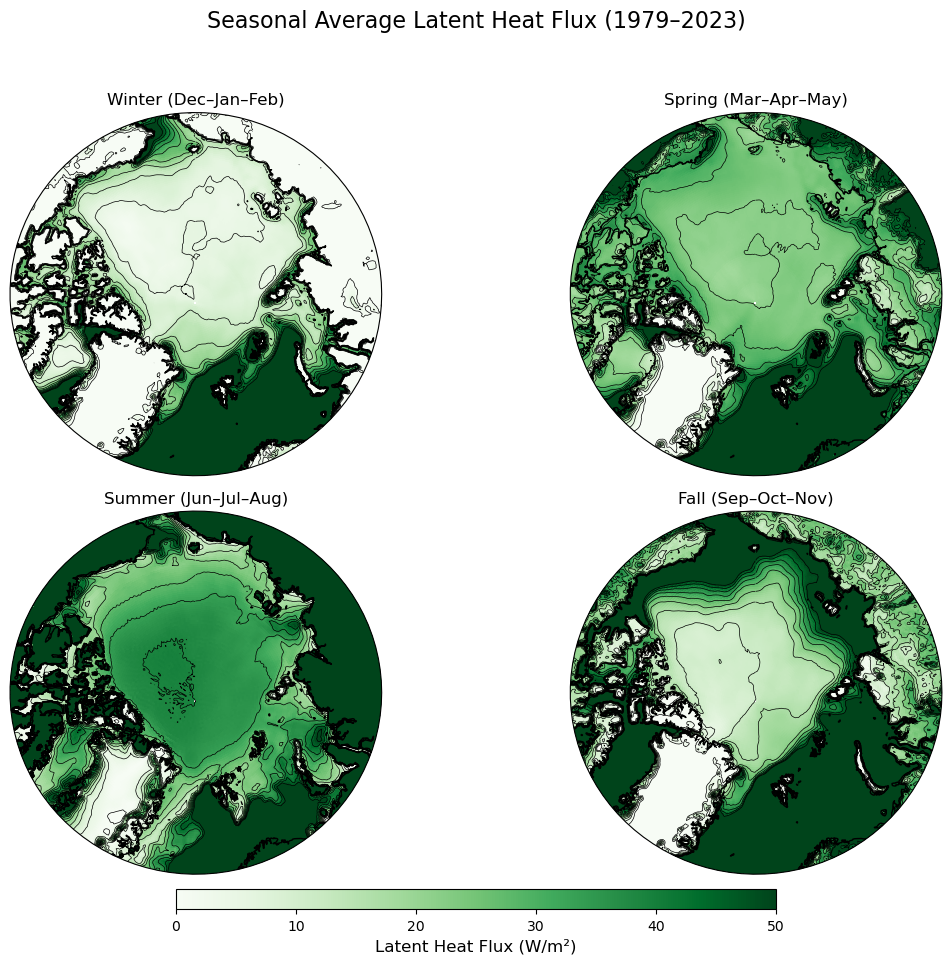

In [32]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpath

# --- Load Dataset ---
ds = xr.open_dataset("reanalysis-era5-single-levels-monthly-means-6b00e1f3fc2180816dd8fb189f3e17d7.nc")

# --- Assign datetime coordinate ---
ds = ds.assign_coords(date=("valid_time", pd.to_datetime(ds.valid_time.values)))

# --- Extract SLHF and convert to W/m² ---
slhf = ds['slhf']
latent_flux = -1 * slhf / 21600  # flip sign → upward positive

# --- Define seasons and assign labels ---
def get_season(month):
    if month in [12, 1, 2]: return 'Winter (Dec–Jan–Feb)'
    elif month in [3, 4, 5]: return 'Spring (Mar–Apr–May)'
    elif month in [6, 7, 8]: return 'Summer (Jun–Jul–Aug)'
    else: return 'Fall (Sep–Oct–Nov)'

season_names = ['Winter (Dec–Jan–Feb)', 'Spring (Mar–Apr–May)',
                'Summer (Jun–Jul–Aug)', 'Fall (Sep–Oct–Nov)']

season_labels = xr.apply_ufunc(
    np.vectorize(get_season, otypes=[str]),
    ds['date'].dt.month
)
latent_flux.coords['season'] = season_labels

# --- Compute seasonal means ---
latent_seasonal = latent_flux.groupby('season').mean('valid_time').sel(season=season_names)

# --- Plotting function ---
def plot_latent_flux_seasons(data, cmap='Greens', vmin=0, vmax=50):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10),
                             subplot_kw={'projection': ccrs.Orthographic(central_latitude=90)})

    for ax, season in zip(axes.flat, season_names):
        ax.set_global()
        ax.coastlines()
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        ax.set_extent([-180, 180, 66.5, 90], crs=ccrs.PlateCarree())

        # Circular Arctic boundary
        theta = np.linspace(0, 2 * np.pi, 100)
        circle = mpath.Path(np.vstack([np.cos(theta), np.sin(theta)]).T * 0.5 + 0.5)
        ax.set_boundary(circle, transform=ax.transAxes)

        dat = data.sel(season=season)
        pcm = ax.pcolormesh(dat.longitude, dat.latitude, dat,
                            transform=ccrs.PlateCarree(), cmap=cmap,
                            shading='auto', vmin=vmin, vmax=vmax)

        ax.contour(dat.longitude, dat.latitude, dat,
                   levels=np.linspace(vmin, vmax, 10),
                   colors='black', linewidths=0.5,
                   transform=ccrs.PlateCarree())

        ax.set_title(season, fontsize=12)

    # Colorbar
    cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])
    cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='horizontal')
    cbar.set_label("Latent Heat Flux (W/m²)", fontsize=12)

    plt.suptitle("Seasonal Average Latent Heat Flux (1979–2023)", fontsize=16)
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    plt.show()

# --- Plot ---
plot_latent_flux_seasons(latent_seasonal)


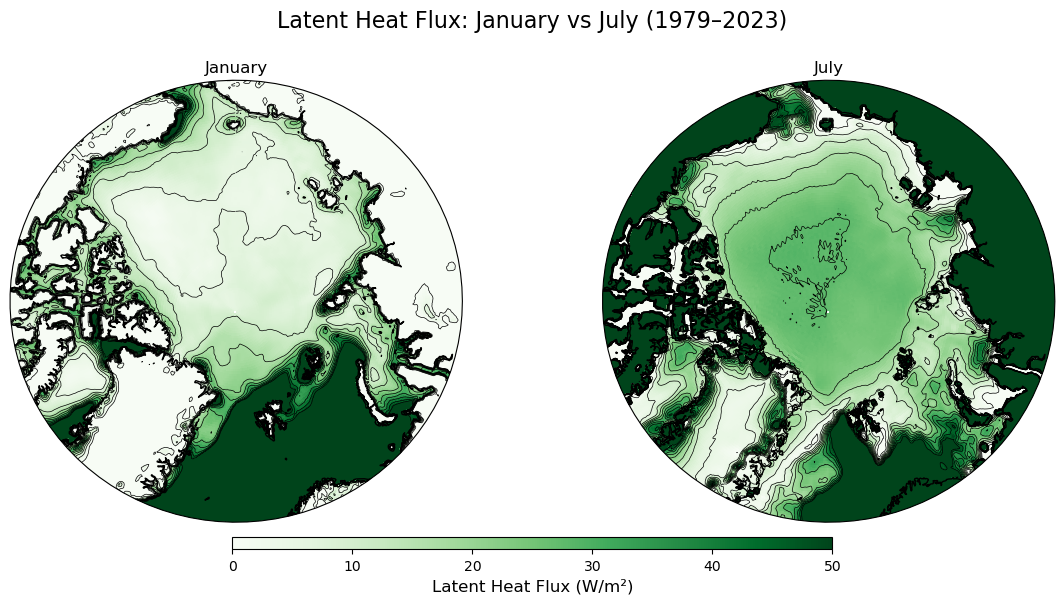

In [34]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpath

# --- Load Dataset ---
ds = xr.open_dataset("reanalysis-era5-single-levels-monthly-means-6b00e1f3fc2180816dd8fb189f3e17d7.nc")

# --- Assign datetime coordinate ---
ds = ds.assign_coords(date=("valid_time", pd.to_datetime(ds.valid_time.values)))

# --- Extract SLHF and convert to W/m² ---
slhf = ds['slhf']
latent_flux = -1 * slhf / 21600  # W/m², upward positive

# --- Select January and July ---
january = latent_flux.sel(valid_time=latent_flux['date'].dt.month == 1)
july = latent_flux.sel(valid_time=latent_flux['date'].dt.month == 7)

# --- Compute monthly means ---
monthly_means = {
    'January': january.mean('valid_time'),
    'July': july.mean('valid_time')
}

# --- Plotting function for January and July ---
def plot_latent_flux_jan_jul(data_dict, cmap='Greens', vmin=0, vmax=50):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6),
                             subplot_kw={'projection': ccrs.Orthographic(central_latitude=90)})

    for ax, (label, dat) in zip(axes, data_dict.items()):
        ax.set_global()
        ax.coastlines()
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        ax.set_extent([-180, 180, 66.5, 90], crs=ccrs.PlateCarree())

        # Arctic circle
        theta = np.linspace(0, 2 * np.pi, 100)
        circle = mpath.Path(np.vstack([np.cos(theta), np.sin(theta)]).T * 0.5 + 0.5)
        ax.set_boundary(circle, transform=ax.transAxes)

        pcm = ax.pcolormesh(dat.longitude, dat.latitude, dat,
                            transform=ccrs.PlateCarree(), cmap=cmap,
                            shading='auto', vmin=vmin, vmax=vmax)

        ax.contour(dat.longitude, dat.latitude, dat,
                   levels=np.linspace(vmin, vmax, 10),
                   colors='black', linewidths=0.5,
                   transform=ccrs.PlateCarree())

        ax.set_title(label, fontsize=12)

    # Colorbar
    cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])
    cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='horizontal')
    cbar.set_label("Latent Heat Flux (W/m²)", fontsize=12)

    plt.suptitle("Latent Heat Flux: January vs July (1979–2023)", fontsize=16)
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    plt.show()

# --- Plot it ---
plot_latent_flux_jan_jul(monthly_means)


C:\Users\zaca1262\AppData\Local\Temp\ipykernel_18212\856307810.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.95])


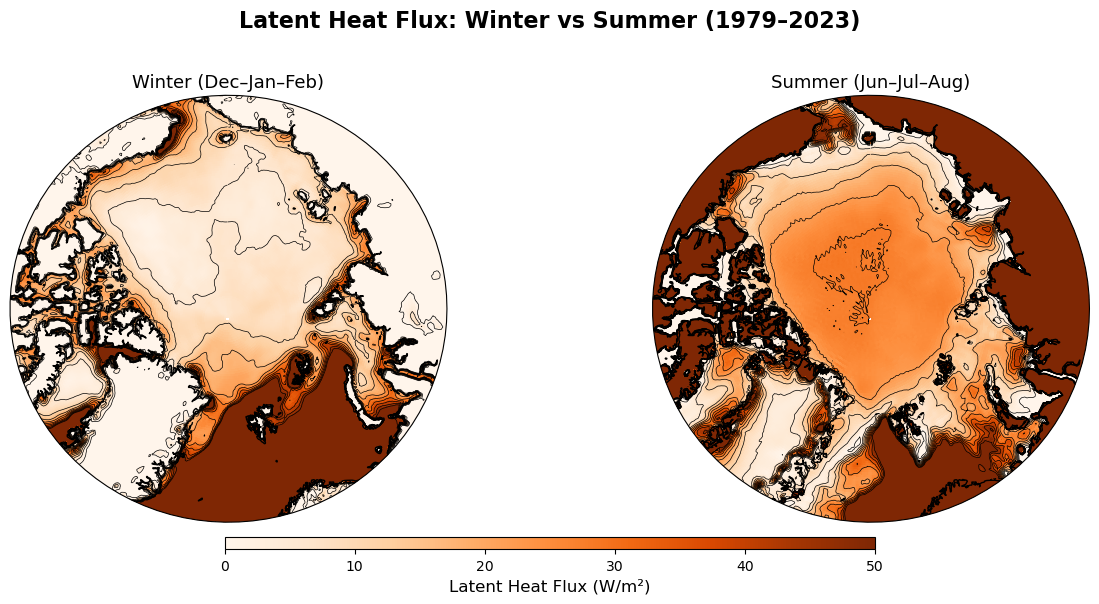

In [4]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpath

# --- Load Dataset ---
ds = xr.open_dataset("reanalysis-era5-single-levels-monthly-means-6b00e1f3fc2180816dd8fb189f3e17d7.nc")

# --- Assign datetime coordinate ---
ds = ds.assign_coords(date=("valid_time", pd.to_datetime(ds.valid_time.values)))

# --- Extract SLHF and convert to W/m² ---
slhf = ds['slhf']
latent_flux = -1 * slhf / 21600  # W/m², upward is positive

# --- Select January and July ---
january = latent_flux.sel(valid_time=latent_flux['date'].dt.month == 1)
july = latent_flux.sel(valid_time=latent_flux['date'].dt.month == 7)

# --- Compute monthly means ---
monthly_means = {
    'Winter (Dec–Jan–Feb)': january.mean('valid_time'),
    'Summer (Jun–Jul–Aug)': july.mean('valid_time')
}

# --- Plotting function for January and July with seasonal labels ---
def plot_latent_flux_jan_jul(data_dict, cmap='Oranges', vmin=0, vmax=50):
    fig, axes = plt.subplots(1, 2, figsize=(13, 6),
                             subplot_kw={'projection': ccrs.Orthographic(central_latitude=90)})

    for ax, (season, dat) in zip(axes, data_dict.items()):
        ax.set_global()
        ax.coastlines()
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        ax.set_extent([-180, 180, 66.5, 90], crs=ccrs.PlateCarree())

        # Arctic circle
        theta = np.linspace(0, 2 * np.pi, 100)
        circle = mpath.Path(np.vstack([np.cos(theta), np.sin(theta)]).T * 0.5 + 0.5)
        ax.set_boundary(circle, transform=ax.transAxes)

        pcm = ax.pcolormesh(dat.longitude, dat.latitude, dat,
                            transform=ccrs.PlateCarree(), cmap=cmap,
                            shading='auto', vmin=vmin, vmax=vmax)

        ax.contour(dat.longitude, dat.latitude, dat,
                   levels=np.linspace(vmin, vmax, 10),
                   colors='black', linewidths=0.5,
                   transform=ccrs.PlateCarree())

        ax.set_title(season, fontsize=13)

    # Colorbar
    cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])
    cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='horizontal')
    cbar.set_label("Latent Heat Flux (W/m²)", fontsize=12)

    plt.suptitle("Latent Heat Flux: Winter vs Summer (1979–2023)", fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    plt.show()

# --- Plot ---
plot_latent_flux_jan_jul(monthly_means)


C:\Users\zaca1262\AppData\Local\Temp\ipykernel_18212\3577970767.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.95])


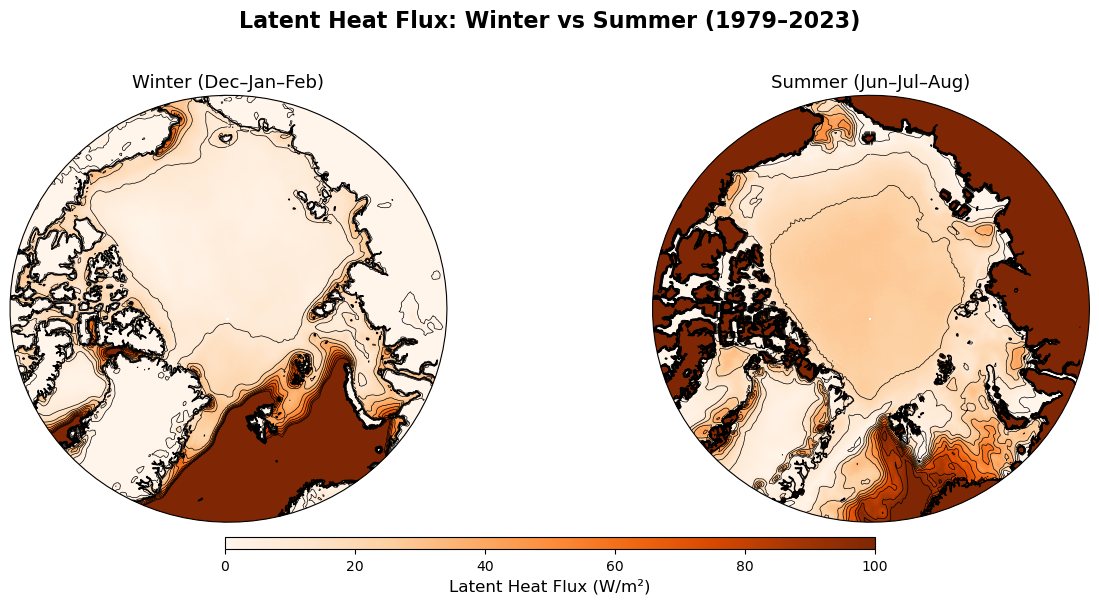

In [5]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpath

# --- Load Dataset ---
ds = xr.open_dataset("reanalysis-era5-single-levels-monthly-means-6b00e1f3fc2180816dd8fb189f3e17d7.nc")

# --- Assign datetime coordinate ---
ds = ds.assign_coords(date=("valid_time", pd.to_datetime(ds.valid_time.values)))

# --- Extract SLHF and convert to W/m² ---
slhf = ds['slhf']
latent_flux = -1 * slhf / 21600  # W/m², upward is positive

# --- Select January and July ---
january = latent_flux.sel(valid_time=latent_flux['date'].dt.month == 1)
july = latent_flux.sel(valid_time=latent_flux['date'].dt.month == 7)

# --- Compute monthly means ---
monthly_means = {
    'Winter (Dec–Jan–Feb)': january.mean('valid_time'),
    'Summer (Jun–Jul–Aug)': july.mean('valid_time')
}

# --- Plotting function for January and July with seasonal labels ---
def plot_latent_flux_jan_jul(data_dict, cmap='Oranges', vmin=0, vmax=100):
    fig, axes = plt.subplots(1, 2, figsize=(13, 6),
                             subplot_kw={'projection': ccrs.Orthographic(central_latitude=90)})

    for ax, (season, dat) in zip(axes, data_dict.items()):
        ax.set_global()
        ax.coastlines()
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        ax.set_extent([-180, 180, 66.5, 90], crs=ccrs.PlateCarree())

        # Arctic circle
        theta = np.linspace(0, 2 * np.pi, 100)
        circle = mpath.Path(np.vstack([np.cos(theta), np.sin(theta)]).T * 0.5 + 0.5)
        ax.set_boundary(circle, transform=ax.transAxes)

        pcm = ax.pcolormesh(dat.longitude, dat.latitude, dat,
                            transform=ccrs.PlateCarree(), cmap=cmap,
                            shading='auto', vmin=vmin, vmax=vmax)

        ax.contour(dat.longitude, dat.latitude, dat,
                   levels=np.linspace(vmin, vmax, 10),
                   colors='black', linewidths=0.5,
                   transform=ccrs.PlateCarree())

        ax.set_title(season, fontsize=13)

    # Colorbar
    cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])
    cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='horizontal')
    cbar.set_label("Latent Heat Flux (W/m²)", fontsize=12)

    plt.suptitle("Latent Heat Flux: Winter vs Summer (1979–2023)", fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    plt.show()

# --- Plot ---
plot_latent_flux_jan_jul(monthly_means)